In [1]:
from torchvision.datasets import mnist,CIFAR10,ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision.utils import save_image

In [2]:
import torch.nn.functional as F
from torch import nn

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=4,kernel_size=5,stride=1,padding=2)#1*28*28->4*28*28->4*14*14          
        self.conv2 = nn.Conv2d(4,8,5,padding=2)#4*14*14->8*14*14->8*7*7
        self.fc1 = nn.Linear(8*7*7,500)
        self.fc2 = nn.Linear(500,10)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)  
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):#64*1*28*28
        x = F.relu(self.conv1(x))#64*4*28*28
        x = self.pool(x)#64*4*14*14
        x = F.relu(self.conv2(x))#64*8*14*14
        x = self.pool(x)#64*8*7*7
        #x = x.view(-1,8*7*7)
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))#64*500
        x = self.dropout(x)#64*500
        x = self.fc2(x)#64*10
        x = F.softmax(x,dim=1)#64*10
        return x

In [18]:
class SurFree:
    def __init__(self,dataset):
        train_batch_size = 64
        test_batch_size = 64
        self.device = torch.device('cuda:0')
        self.dataset = dataset
        if dataset == 'mnist':
            self.transform = transforms.ToTensor()
            self.trainSet = mnist.MNIST('./data', train=True, download=True,transform=self.transform)
            self.testSet = mnist.MNIST('./data', train=False, transform=self.transform)
            self.classes = ('0','1','2','3','4','5','6','7','8','9')
            self.model = CNN()
        elif dataset == 'cifar10':
            self.transform = transforms.Compose([transforms.Resize(224),transforms.ToTensor()])
            self.trainSet = CIFAR10(root='./data', train=True,download=True, transform=self.transform)
            self.testSet = CIFAR10(root='./data', train=False,download=True, transform=self.transform)
            self.classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
            self.model = resnet18(pretrained=True)
            self.model.fc = nn.Linear(self.model.fc.in_features,10)
            
        self.trainLoader = DataLoader(self.trainSet, batch_size=train_batch_size,shuffle=True)
        self.testLoader = DataLoader(self.testSet, batch_size=test_batch_size,shuffle=False)
        self.shape = self.trainSet[0][0].shape
        self.channel = self.shape[0]
        self.modelPath = f'model_for_{dataset}'
        
        try:
            self._load()
        except:
            pass
        
        self.l = 10 # times of binary search
        self.T = 3 # sign search
        self.k = 0.02 # decrease theta_max rate 
        self.L = 100 # length of V
        self.tao = torch.zeros(2*self.T)
        for i in range(2*self.T):
            if i%2:
                self.tao[i] = -(self.T-(i-1)/2)/self.T
            else:
                self.tao[i] = (self.T-i/2)/self.T
                
        
    def _save(self):
        self.model.to('cpu')
        torch.save(self.model.state_dict(), self.modelPath)
        print('---model saved----')

    def _load(self):
        self.model.load_state_dict(torch.load(self.modelPath))
        print('---model loaded----')

    def display(self,img):
        npimg  = img.clone().detach().numpy()
        #shape = npimg.shape
        #npimg = (npimg.reshape(shape[0],-1) * np.array(std).reshape(-1,1)+np.array(mean).reshape(-1,1)).reshape(shape)
        plt.xticks([])
        plt.yticks([])
        plt.title(f'predict:{self.classes[self.model(img.unsqueeze(0).to(self.device)).max(1)[1].item()]}')
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
    def _test(self):
        device = torch.device("cuda:0")
        self.model.to(device)
        testAccuracy = 0
        with torch.no_grad():
            self.model.eval()
            for image, label in self.testLoader:
                image=image.to(device)
                label = label.to(device)
                out = self.model(image)

                predict = out.max(1)[1]
                testAccuracy += (predict == label).sum().item()

            testAccuracy/=len(self.testSet)
        print(f'Test Accuracy:{testAccuracy*100:.1f}%')
        self.model.to('cpu')
        
    def train(self,epoch=5):
        print('----train start----')
        device = torch.device("cuda:0")
        try:
            self._load()
        except:
            pass
        self.model.to(device)
        loss_func = CrossEntropyLoss()
        optimizer = Adam(self.model.parameters())

        trainAccuracy = 0
        for i in range(epoch):
            self.model.train()
            for image, label in self.trainLoader:
                image=image.to(device)
                label = label.to(device)
                out = self.model(image)
                loss = loss_func(out, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                predict = out.max(1)[1]
                trainAccuracy += (predict == label).sum().item()

            trainAccuracy/=len(self.trainSet)

            print(f'epoch:{i}  Train Accuracy:{trainAccuracy*100:.1f}%',end=' ')
            self._test()
        print('----train finish----')
        self._save()
        
    def _is_adversarial(self,x):
        self.query += 1
#         if self.query in [100,500,1000]:
#             self.images.append(x.reshape(self.shape))
#             print(self.query,self._l2_norm_distance(x,self.xo))
        self.distortion.append(self._l2_norm_distance(x,self.xo))
        return self.model(x.reshape(1,*self.shape).to(self.device)).max(1)[1].item() != self.xo_classification
    
    def _l2_norm_distance(self,x1,x2):
        d = np.linalg.norm(x1-x2,axis=1)
        return np.linalg.norm(d)
    
    def _inner_dot(self,x,y):
        dot = x*y
        dot = dot.sum(1).reshape(-1,1)
        return dot

    def _schmidt(self,uk,tk):
        #V是之前生成的标准正交基
        uk_ = uk.clone()
        vk = tk.clone()
        for vi in self.V:
            uk_ -= vi*self._inner_dot(uk,vi)
            vk -= vi*self._inner_dot(tk,vi)
        uk_ /= np.linalg.norm(uk_,axis=1).reshape(-1,1)
        vk -= uk_*self._inner_dot(tk,uk_)
        vk /= np.linalg.norm(vk,axis=1).reshape(-1,1)
        return vk
        
    def generate_adversarial(self,xo,queryLimited = 5000):
        self.model.eval()#important!!!
        self.model.to(self.device)
        self.theta_max = 30
        self.query = 0
        self.distortion = []
        
        self.xo_classification = self.model(xo.unsqueeze(0).to(self.device)).max(1)[1].item()
        self.xo = xo.flatten(1)
        # find y0 which is another classification
        while True:
            index = torch.randint(0,len(self.trainSet),(1,)).item()
            y_adv = self.trainSet[index][1]
            if y_adv !=self.xo_classification:
                break
        y0 = self.trainSet[index][0].flatten(1)
        
        # find the initial adverarial by binary search
        low = 0
        high = 1
        find = False
        step = 0
        while step<self.l or not find:
            step += 1
            mid = (low+high)/2
            y = mid*self.xo + (1-mid)*y0
            if self._is_adversarial(y):
                low = mid
                find = True
            else:
                high = mid
                find = False
                
        x = y
        self.D = self.xo.shape[1]
        self.V = []
        for epoch in range(self.D-1):
            if queryLimited>0:
                if self.query > queryLimited:
                    break
            d = torch.Tensor(np.linalg.norm(x-self.xo,axis=1).reshape(-1,1))
            u = (x-self.xo)/d
            success = False

            if epoch%50==0:
                print(f'{epoch=},query={self.query},d={self._l2_norm_distance(x,self.xo):.2f}')

            while not success:
                t = torch.Tensor(np.random.normal(0, 1, (self.channel,self.D)))
                t = t/np.linalg.norm(t,axis=1).reshape(-1,1)
                #根据u生成v
                v = self._schmidt(u,t)
                self.V.append(v)
                if len(self.V)>self.L:
                    self.V = self.V[1:]
                #根据u v 生成x
                index = 0
                while index < 2*self.T:
                    t = self.tao[index]
                    index += 1
                    theta = self.theta_max * t * np.pi / 180
                    n = np.cos(theta)*u + np.sin(theta)*v
                    x = (d * np.cos(theta)*n+self.xo).clip(0,1) # 这个公式保证了d是单调减的
                    if self._is_adversarial(x):
                        success = True
                        break
                #二分搜索找边界
                if success:
                    t = self.tao[index-1]
                    low = t
                    high = t + np.sign(t)
                    step = 0
                    find = False
                    while step < self.l or not find:
                        step += 1
                        mid = (low+high)/2
                        theta = self.theta_max * mid * np.pi / 180
                        n = np.cos(theta)*u + np.sin(theta)*v
                        x = (d * np.cos(theta)*n+self.xo).clip(0,1)#clip的范围必须和预处理时归一化的范围一致
                        if self._is_adversarial(x):
                            low = mid
                            find = True
                        else:
                            high = mid
                            find = False
                    self.theta_max /= 1-self.k
                else:
                    self.theta_max *= 1-self.k
                    self.V.pop()
                    
        self.xo =xo.reshape(self.shape)
        self.x = x.reshape(self.shape)
        return self.x

    def test(self,classification=0,query=5000):
        self.model.eval()
        self.model.to(self.device)
        index = torch.randint(0,len(self.trainSet),(1,)).item()
        while True:
            xo = self.trainSet[index][0]
            y_true = self.trainSet[index][1]
            pre = self.model(xo.unsqueeze(0).to(self.device)).max(1)[1].item() 
            if y_true == classification and y_true == pre:
                break
            else:
                index = torch.randint(0,len(self.trainSet),(1,)).item()
        #self.display(xo)
        x = self.generate_adversarial(xo,query)
        self.display(x)
        
    def generate_all(self):
        self.model.eval()
        self.model.to(surfree.device)
        for cls in range(10):
            for num in range(10):
                index = torch.randint(0,len(self.trainSet),(1,)).item()
                find = False
                while not find:
                    xo = self.trainSet[index][0]
                    y_true = self.trainSet[index][1]
                    if y_true == cls:
                        pre = self.model(xo.unsqueeze(0).to(self.device)).max(1)[1].item() 
                        if y_true == pre:
                            find = True
                    index = torch.randint(0,len(self.trainSet),(1,)).item()
                x = self.generate_adversarial(xo,10000)
                save_image(x,f'adv/{self.dataset}/{cls}/{num}.png')#保存后再重新读入的tensor并不完全相同 有50%的概率会变成非对抗样本
    def exam(self):
        #攻击成功率并非100% 原因见上个函数的注释
        advset = ImageFolder(f'adv/{self.dataset}',transform = self.transform)
        self.model.eval()
        self.model.to(self.device)
        for x, y in advset:
            x = x.unsqueeze(0).to(surfree.device)
            y1 = surfree.model(x).max(1)[1].item()
            print(y,y1)

            

In [19]:
surfree = SurFree('mnist')

---model loaded----


epoch=0,query=11,d=4.48
epoch=50,query=1699,d=3.89
epoch=100,query=2800,d=3.57
epoch=150,query=3874,d=3.41
epoch=200,query=4937,d=3.22


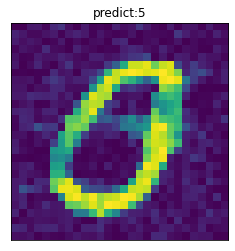

In [20]:
surfree.test()